# Applying SDG labels to publications

This script makes use of the Open SDG project (https://osdg.ai/) and (https://github.com/osdg-ai/osdg-tool/tree/pre-release) to determine which SDG labels should be applied to publications based on the title + abstract. 

This notebook requires that a OpenSDG docker image is running somewhere. There is currently (2021-11-29) one running on the docker-dev machine and has port 5001 mapped to the correct container port.


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
osdg_url = 'http://docker-dev.vliz.be:5001/tag' 

### Get the data and labels from the server

In [3]:
# Specify location of data:
datafolder = "user-analysis/LW_publications_standardized" 
datafiles = ["LWpubs_stand_0_500.csv", 
             "LWpubs_stand_500_1000.csv", 
             "LWpubs_stand_1000_1500.csv", 
             "LWpubs_stand_1500_2000.csv", 
             "LWpubs_stand_2000_2500.csv",
             "LWpubs_stand_2500_3000.csv",
             "LWpubs_stand_3000_3500.csv",
             "LWpubs_stand_3500_4000.csv",
             "LWpubs_stand_4000_4500.csv",
             "LWpubs_stand_4500_5000.csv",
             "LWpubs_stand_5000_5500.csv",
             "LWpubs_stand_5500_6000.csv",
             "LWpubs_stand_6000_6227.csv"]

# Load data into single dataframe
appended_data = []
for datafile in datafiles:
    data_loc = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), datafolder, datafile)
    data = pd.read_csv(data_loc)
    data.rename(columns={'SortDate': 'Year'}, inplace=True)
    appended_data.append(data)
    
data = pd.concat(appended_data)

# Exclude publications from 2022:
data = data[data['Year']<2022]

# Set correct types
data['BrefID'] = data['BrefID'].astype("category")
data['Year'] = data['Year'].astype("category")

In [4]:
def get_sdg(row):
    '''
    This function takes a pandas row and returns the same row with two additional columns. The "status" row is
    generally used for the http status of the request (I think) and the "result" row contains a dict 
    of <SDG_#>:<relevance> that has values for all SDG numbers that score > 0 on the relevance. 
    '''
    text = str(row['StandardTitle']) + str(row['AbstractEnglish'])
    text_dict = {'text':text}
    try:
        response = requests.post(osdg_url, json=text_dict)
        result = response.json()
        row['result_status'] = result['status']
        row['result'] = {item['sdg']:item['relevance'] for item in result['result']}  
    except Exception as err:
        print('Something went wrong')
        row['result_status'] = 'nOK'
        row['result'] = [err]
    return row

In [5]:
# Get SDG tags. This is an expensive query and requires that the docker server be running.
# So for now it's commented out. 
reprocess = False
if reprocess == True:
    data_sdg  = data.apply(lambda row: get_sdg(row), axis=1)
    data_sdg.to_csv('/home/jovyan/work/user-analysis/LW_publications_standardized/LWpubs_stand_all_SDG.csv')
    data_sdg = data_sdg.join(data_sdg['result'].apply(pd.Series))
    data_sdg['SDG_None'] = data_sdg.apply(lambda row: not(row['result']), axis=1)
else: 
    data_sdg  = pd.read_csv('/home/jovyan/work/user-analysis/LW_publications_standardized/LWpubs_stand_all_SDG.csv')
    data_sdg = data_sdg.join(data_sdg['result'].map(eval).apply(pd.Series))
    data_sdg['SDG_None'] =  data_sdg.apply(lambda row: (row['result'] == '{}'), axis=1)


## Some SDG results:

In [6]:
cols_of_interest = ['SDG_None',
        'SDG_14',
        'SDG_2',
        'SDG_3',
        'SDG_15',
        'SDG_11',
        'SDG_6',
        'SDG_13',
        'SDG_9',
        'SDG_7',
        'SDG_16',
        'SDG_10',
        'SDG_12',
        'SDG_8',
        'SDG_1',
        'SDG_4',
        'SDG_5',] 

sdg_dict = {'SDG_1': 'GOAL 1: No Poverty',
            'SDG_2': 'GOAL 2: Zero Hunger',
            'SDG_3': 'GOAL 3: Good Health and Well-being',
            'SDG_4': 'GOAL 4: Quality Education',
            'SDG_5': 'GOAL 5: Gender Equality',
            'SDG_6': 'GOAL 6: Clean Water and Sanitation',
            'SDG_7': 'GOAL 7: Affordable and Clean Energy',
            'SDG_8': 'GOAL 8: Decent Work and Economic Growth',
            'SDG_9': 'GOAL 9: Industry, Innovation and Infrastructure',
            'SDG_10': 'GOAL 10: Reduced Inequality',
            'SDG_11': 'GOAL 11: Sustainable Cities and Communities',
            'SDG_12': 'GOAL 12: Responsible Consumption and Production',
            'SDG_13': 'GOAL 13: Climate Action',
            'SDG_14': 'GOAL 14: Life Below Water',
            'SDG_15': 'GOAL 15: Life on Land',
            'SDG_16': 'GOAL 16: Peace and Justice Strong Institutions',
            'SDG_17': 'GOAL 17: Partnerships to achieve the Goal',
            'SDG_None': 'Publication not matched to any Goal'}


# Count the number of SDG publications per year
data_agg = data_sdg.groupby(['Year']).count() 


In [7]:
data_agg

,Unnamed: 0,Unnamed: 0.1,BrefID,BibLvlCode,StandardTitle,RefStrFull,AbstractEnglish,Refstringauthors,WoScode,FullAut,...,SDG_12,SDG_1,SDG_10,SDG_11,SDG_16,SDG_8,SDG_9,SDG_4,SDG_5,SDG_None
Year,,,,,,,,,,,,,,,,,,,,,
2012,231,231,231,231,231,231,194,228,145,228,...,4,1,2,17,5,1,15,2,0,231
2013,342,342,342,342,342,342,278,340,223,340,...,2,0,7,29,5,4,16,1,0,342
2014,381,381,381,381,381,381,316,376,263,376,...,4,0,5,37,13,1,27,3,0,381
2015,386,386,386,386,386,386,325,383,292,383,...,5,4,9,46,15,3,24,0,0,386
2016,334,334,334,334,334,334,243,332,212,332,...,4,8,4,32,10,1,23,1,0,334
2017,442,442,442,442,442,442,336,441,247,441,...,3,0,7,32,11,2,19,1,0,442
2018,902,902,902,902,902,902,711,901,602,901,...,12,4,12,76,21,4,52,5,1,902
2019,1046,1046,1046,1046,1046,1046,769,1046,677,1045,...,13,7,15,85,28,7,52,2,1,1046
2020,1288,1288,1288,1288,1288,1288,847,1283,753,1277,...,17,4,23,99,29,11,70,4,1,1288


SDG_1


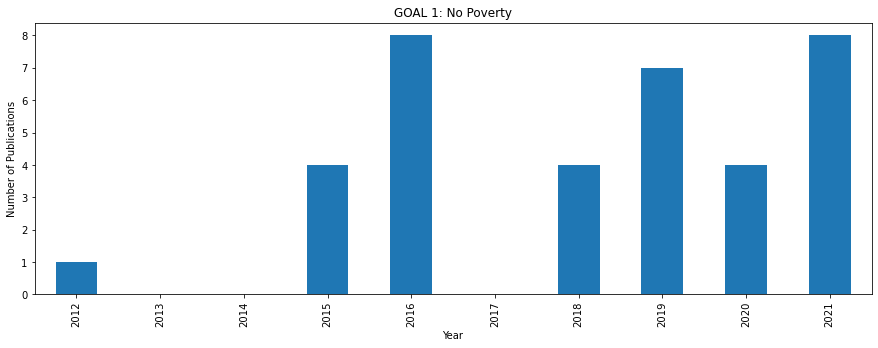

SDG_2


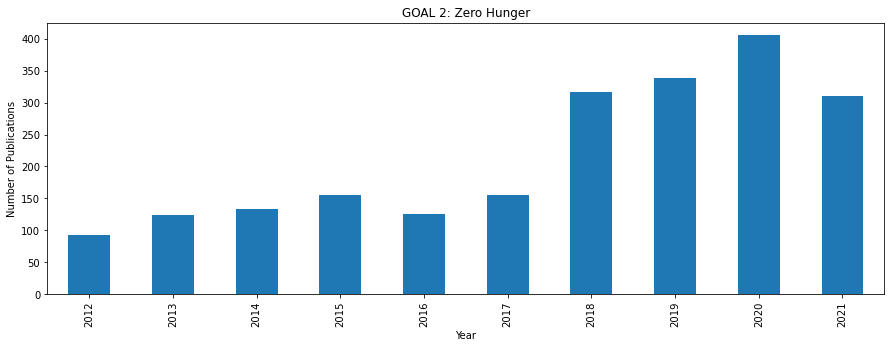

SDG_3


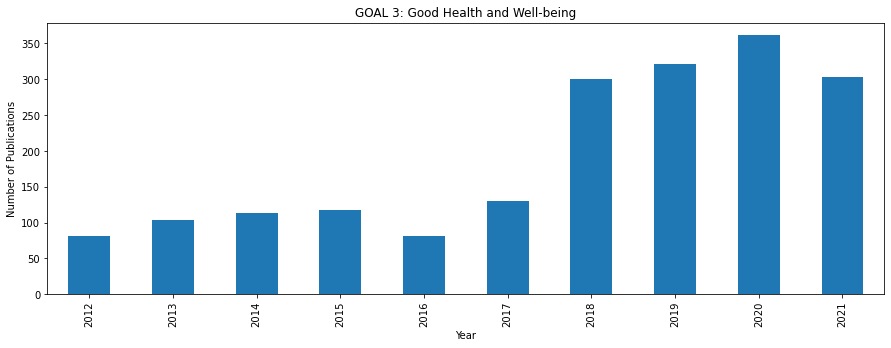

SDG_4


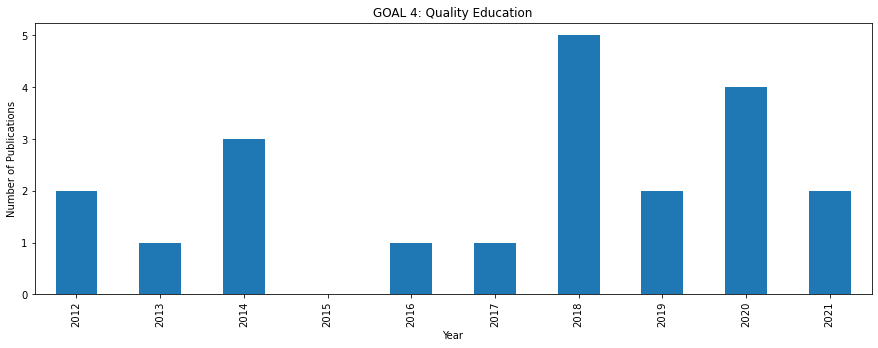

SDG_5


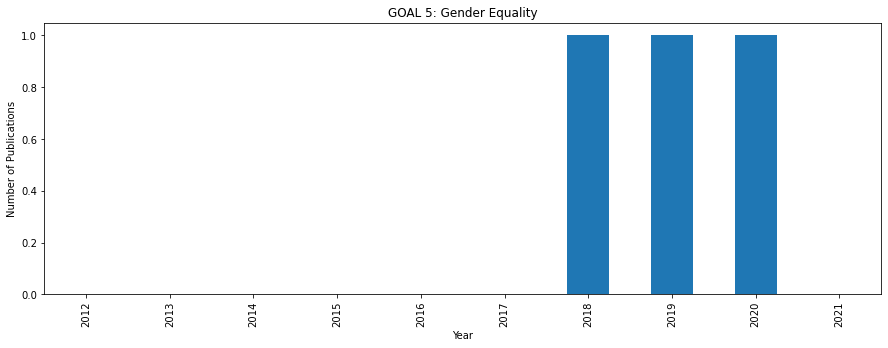

SDG_6


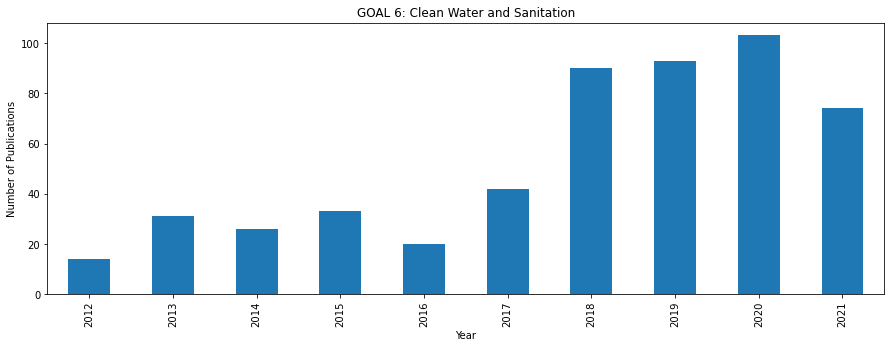

SDG_7


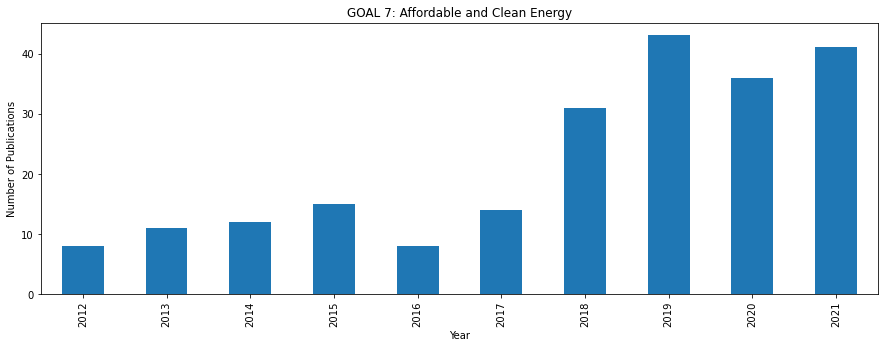

SDG_8


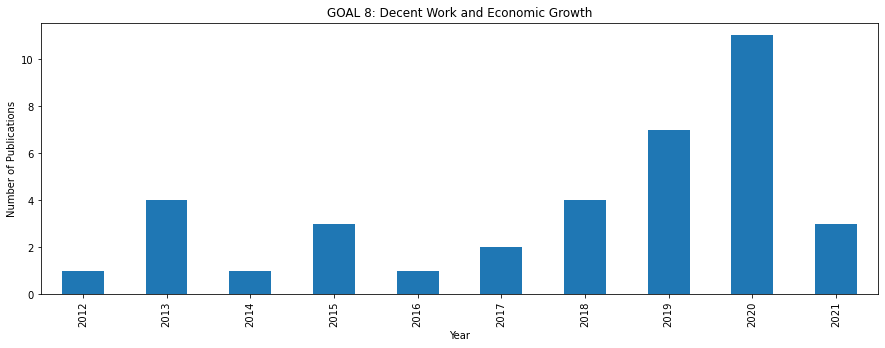

SDG_9


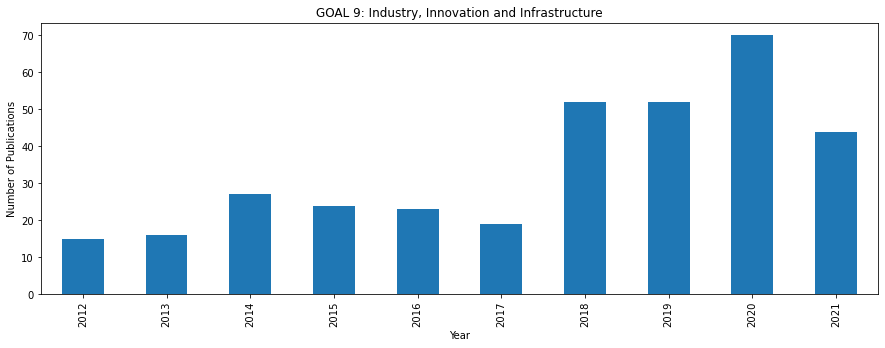

SDG_10


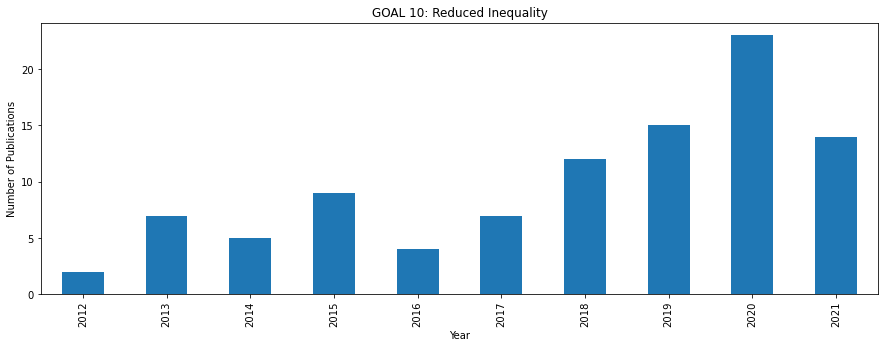

SDG_11


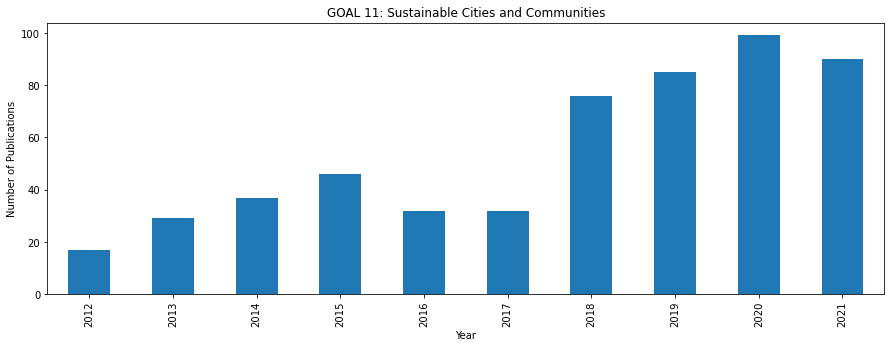

SDG_12


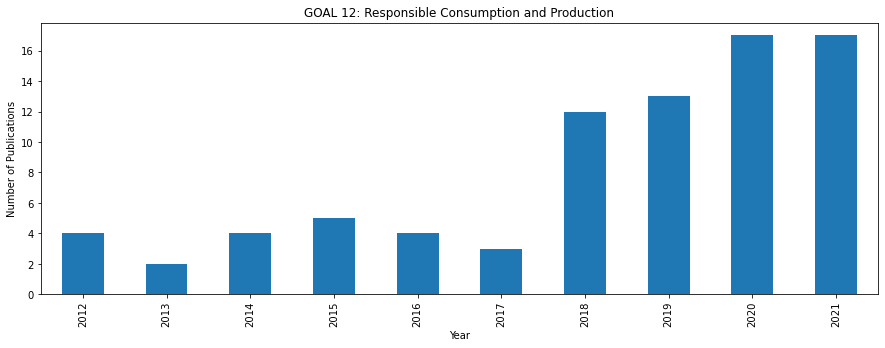

SDG_13


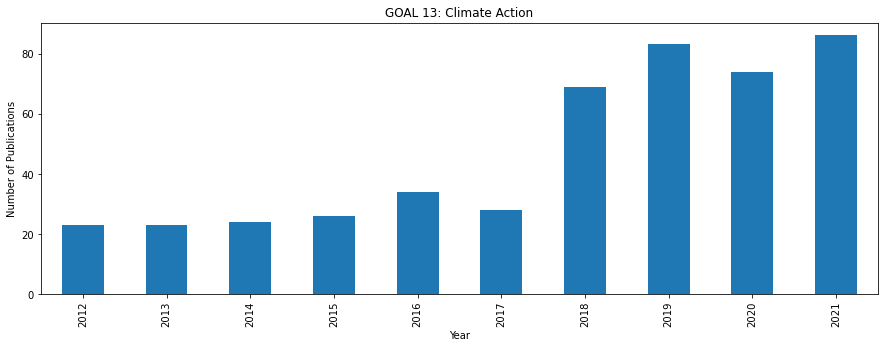

SDG_14


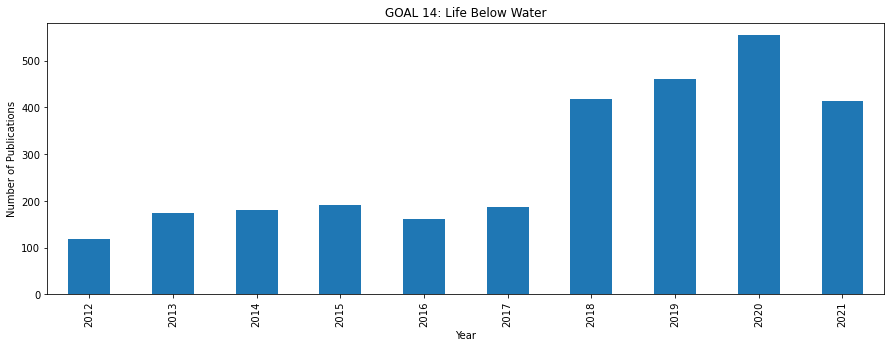

SDG_15


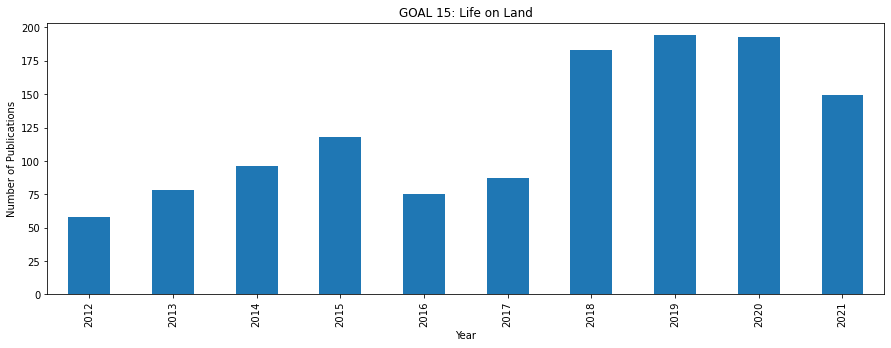

SDG_16


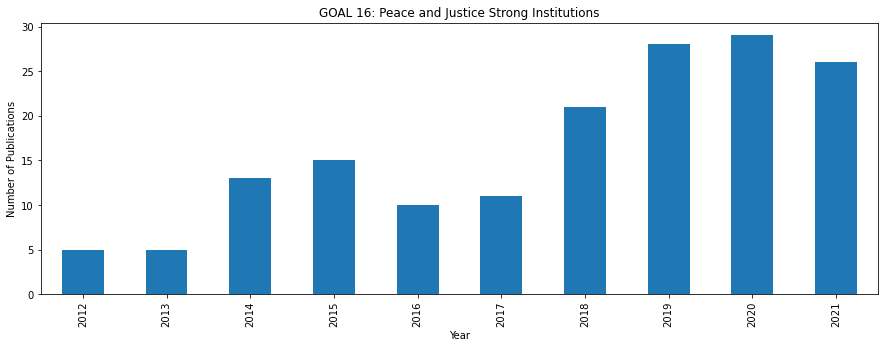

SDG_17
'SDG_17'
SDG_None


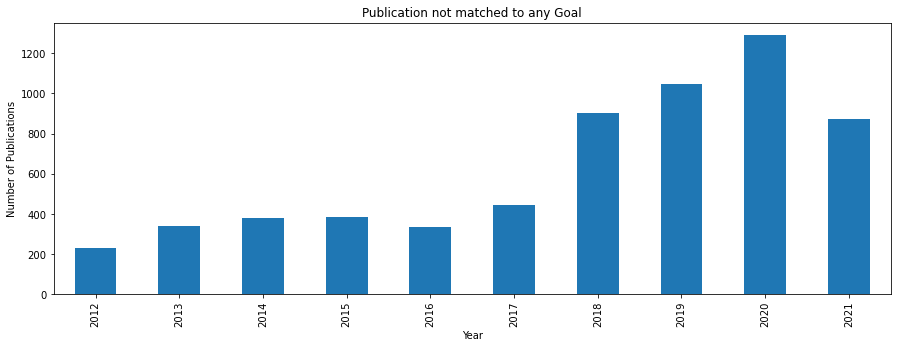

In [8]:
%matplotlib inline

ys = [[0,1,2,3,4],[4,3,2,1,0]]
x_ax = [0,1,2,3,4]

for sdg, title in sdg_dict.items():
    try:
        print(sdg)
        ts = data_agg[sdg]
        ts.plot(kind='bar', figsize=(15,5), title=title, ylabel= 'Number of Publications')
        plt.show()
    except Exception as error:
        print(error)

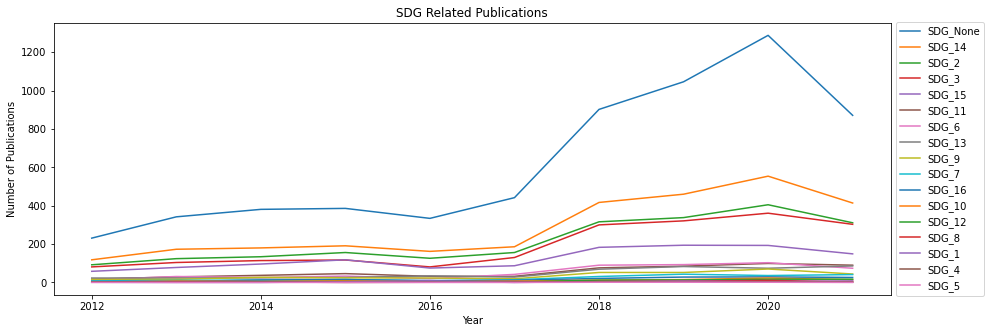

In [9]:

f = plt.figure()

plt.title('SDG Related Publication Count over Time', color='black')
data_agg[cols_of_interest].plot(figsize=(15,5), 
                                title='SDG Related Publications',
                                ylabel= 'Number of Publications', 
                                ax=f.gca())

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()




In [10]:
data_agg[cols_of_interest].sum().sort_values()

SDG_5          3
SDG_4         21
SDG_1         36
SDG_8         37
SDG_12        81
SDG_10        98
SDG_16       163
SDG_7        219
SDG_9        342
SDG_13       470
SDG_6        526
SDG_11       543
SDG_15      1231
SDG_3       1912
SDG_2       2158
SDG_14      2855
SDG_None    6223
dtype: int64

## Results
It seems that the most relevant SDG's for the published datasets, over all the years are:
* SDG 14: Life Below Water with ~2800 Publications
* SDG  2: Zero Hunger with ~2100 publications
* SDG  3: Good Health and Wellbeing with ~1900 publications
* SDG 15: Life on Land with ~1200 publications

SDG 14, Life Below Water, is obviously related to the work being done but the relationships to the other SDG's are not as clear (to me). Gender Equality and Sanition goals are also not seen in marine research publications, which makes sense.

There are also a significant ammount of papers with no SDG mapping

## Sorta Pivot to get the dict info into columns...
Currently the SDG labels are stored in a dict with the SDG# and relevance value. It would be better to have a bunch of columns with the values in there.

https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

And checking the histogram of the results might provide some indication on whether to have a cutoff on "relevance" 